Our next addition to the model is a learning rate scheduler. Specifically, we'll use the one-cycle learning rate policy.

In [20]:
%%writefile ../models/model_6.py

# number of epochs of training
NUM_EPOCHS = 50

import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torchvision import transforms


class BobRossSegmentedImagesDataset(Dataset):
    def __init__(self, dataroot):
        super().__init__()
        self.dataroot = dataroot
        self.imgs = list((self.dataroot / 'train' / 'images').rglob('*.png'))
        self.segs = list((self.dataroot / 'train' / 'labels').rglob('*.png'))
        self.transform = transforms.Compose([
            transforms.Resize((164, 164)),
            transforms.Pad(46, padding_mode='reflect'),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                            mean=(0.459387, 0.46603974, 0.4336706),
                            std=(0.06098535, 0.05802868, 0.08737113)
            )
        ])
        self.color_key = {
            3 : 0,
            5: 1,
            10: 2,
            14: 3,
            17: 4,
            18: 5,
            22: 6,
            27: 7,
            61: 8
        }
        assert len(self.imgs) == len(self.segs)
        # TODO: remean images to N(0, 1)?
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        def translate(x):
            return self.color_key[x]
        translate = np.vectorize(translate)
        
        img = Image.open(self.imgs[i])
        img = self.transform(img)
        
        seg = Image.open(self.segs[i])
        seg = seg.resize((256, 256))
        
        # Labels are in the ADE20K ontology and are not consequetive,
        # we have to apply a remap operation over the labels in a just-in-time
        # manner. This slows things down, but it's fine, this is just a demo
        # anyway.
        seg = translate(np.array(seg)).astype('int64')
        
        # One-hot encode the segmentation mask.
        # def ohe_mat(segmap):
        #     return np.array(
        #         list(
        #             np.array(segmap) == i for i in range(9)
        #         )
        #     ).astype(int).reshape(9, 256, 256)
        # seg = ohe_mat(seg)
        
        # Additionally, the original UNet implementation outputs a segmentation map
        # for a subset of the overall image, not the image as a whole! With this input
        # size the segmentation map targeted is a (164, 164) center crop.
        seg = seg[46:210, 46:210]
        
        return img, seg
    
from torch import nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1_1 = nn.Conv2d(3, 64, 3)
        torch.nn.init.kaiming_normal_(self.conv_1_1.weight)
        self.relu_1_2 = nn.ReLU()
        self.norm_1_3 = nn.BatchNorm2d(64)
        self.conv_1_4 = nn.Conv2d(64, 64, 3)
        torch.nn.init.kaiming_normal_(self.conv_1_4.weight)
        self.relu_1_5 = nn.ReLU()
        self.norm_1_6 = nn.BatchNorm2d(64)
        self.pool_1_7 = nn.MaxPool2d(2)
        
        self.conv_2_1 = nn.Conv2d(64, 128, 3)
        torch.nn.init.kaiming_normal_(self.conv_2_1.weight)        
        self.relu_2_2 = nn.ReLU()
        self.norm_2_3 = nn.BatchNorm2d(128)
        self.conv_2_4 = nn.Conv2d(128, 128, 3)
        torch.nn.init.kaiming_normal_(self.conv_2_4.weight)        
        self.relu_2_5 = nn.ReLU()
        self.norm_2_6 = nn.BatchNorm2d(128)
        self.pool_2_7 = nn.MaxPool2d(2)
        
        self.conv_3_1 = nn.Conv2d(128, 256, 3)
        torch.nn.init.kaiming_normal_(self.conv_3_1.weight)
        self.relu_3_2 = nn.ReLU()
        self.norm_3_3 = nn.BatchNorm2d(256)
        self.conv_3_4 = nn.Conv2d(256, 256, 3)
        torch.nn.init.kaiming_normal_(self.conv_3_4.weight)
        self.relu_3_5 = nn.ReLU()
        self.norm_3_6 = nn.BatchNorm2d(256)
        self.pool_3_7 = nn.MaxPool2d(2)
        
        self.conv_4_1 = nn.Conv2d(256, 512, 3)
        torch.nn.init.kaiming_normal_(self.conv_4_1.weight)
        self.relu_4_2 = nn.ReLU()
        self.norm_4_3 = nn.BatchNorm2d(512)
        self.conv_4_4 = nn.Conv2d(512, 512, 3)
        torch.nn.init.kaiming_normal_(self.conv_4_4.weight)
        self.relu_4_5 = nn.ReLU()
        self.norm_4_6 = nn.BatchNorm2d(512)
        
        # deconv is the '2D transposed convolution operator'
        self.deconv_5_1 = nn.ConvTranspose2d(512, 256, (2, 2), 2)
        # 61x61 -> 48x48 crop
        self.c_crop_5_2 = lambda x: x[:, :, 6:54, 6:54]
        self.concat_5_3 = lambda x, y: torch.cat((x, y), dim=1)
        self.conv_5_4 = nn.Conv2d(512, 256, 3)
        torch.nn.init.kaiming_normal_(self.conv_5_4.weight)        
        self.relu_5_5 = nn.ReLU()
        self.norm_5_6 = nn.BatchNorm2d(256)
        self.conv_5_7 = nn.Conv2d(256, 256, 3)
        torch.nn.init.kaiming_normal_(self.conv_5_7.weight)
        self.relu_5_8 = nn.ReLU()
        self.norm_5_9 = nn.BatchNorm2d(256)
        
        self.deconv_6_1 = nn.ConvTranspose2d(256, 128, (2, 2), 2)
        # 121x121 -> 88x88 crop
        self.c_crop_6_2 = lambda x: x[:, :, 17:105, 17:105]
        self.concat_6_3 = lambda x, y: torch.cat((x, y), dim=1)
        self.conv_6_4 = nn.Conv2d(256, 128, 3)
        torch.nn.init.kaiming_normal_(self.conv_6_4.weight)
        self.relu_6_5 = nn.ReLU()
        self.norm_6_6 = nn.BatchNorm2d(128)
        self.conv_6_7 = nn.Conv2d(128, 128, 3)
        torch.nn.init.kaiming_normal_(self.conv_6_7.weight)
        self.relu_6_8 = nn.ReLU()
        self.norm_6_9 = nn.BatchNorm2d(128)
        
        self.deconv_7_1 = nn.ConvTranspose2d(128, 64, (2, 2), 2)
        # 252x252 -> 168x168 crop
        self.c_crop_7_2 = lambda x: x[:, :, 44:212, 44:212]
        self.concat_7_3 = lambda x, y: torch.cat((x, y), dim=1)
        self.conv_7_4 = nn.Conv2d(128, 64, 3)
        torch.nn.init.kaiming_normal_(self.conv_7_4.weight)
        self.relu_7_5 = nn.ReLU()
        self.norm_7_6 = nn.BatchNorm2d(64)
        self.conv_7_7 = nn.Conv2d(64, 64, 3)
        torch.nn.init.kaiming_normal_(self.conv_7_7.weight)        
        self.relu_7_8 = nn.ReLU()
        self.norm_7_9 = nn.BatchNorm2d(64)
        
        # 1x1 conv ~= fc; n_classes = 9
        self.conv_8_1 = nn.Conv2d(64, 9, 1)

    def forward(self, x):
        x = self.conv_1_1(x)
        x = self.relu_1_2(x)
        x = self.norm_1_3(x)
        x = self.conv_1_4(x)
        x = self.relu_1_5(x)
        x_residual_1 = self.norm_1_6(x)
        x = self.pool_1_7(x_residual_1)
        
        x = self.conv_2_1(x)
        x = self.relu_2_2(x)
        x = self.norm_2_3(x)
        x = self.conv_2_4(x)
        x = self.relu_2_5(x)
        x_residual_2 = self.norm_2_6(x)
        x = self.pool_2_7(x_residual_2)
        
        x = self.conv_3_1(x)
        x = self.relu_3_2(x)
        x = self.norm_3_3(x)
        x = self.conv_3_4(x)
        x = self.relu_3_5(x)
        x_residual_3 = self.norm_3_6(x)
        x = self.pool_3_7(x_residual_3)
        
        x = self.conv_4_1(x)
        x = self.relu_4_2(x)
        x = self.norm_4_3(x)        
        x = self.conv_4_4(x)
        x = self.relu_4_5(x)
        x = self.norm_4_6(x)
        
        x = self.deconv_5_1(x)
        x = self.concat_5_3(self.c_crop_5_2(x_residual_3), x)
        x = self.conv_5_4(x)
        x = self.relu_5_5(x)
        x = self.norm_5_6(x)
        x = self.conv_5_7(x)
        x = self.relu_5_8(x)
        x = self.norm_5_9(x)
        
        x = self.deconv_6_1(x)
        x = self.concat_6_3(self.c_crop_6_2(x_residual_2), x)
        x = self.conv_6_4(x)
        x = self.relu_6_5(x)
        x = self.norm_6_6(x)
        x = self.conv_6_7(x)
        x = self.relu_6_8(x)
        x = self.norm_6_9(x)
        
        x = self.deconv_7_1(x)
        x = self.concat_7_3(self.c_crop_7_2(x_residual_1), x)
        x = self.conv_7_4(x)
        x = self.relu_7_5(x)
        x = self.norm_7_6(x)
        x = self.conv_7_7(x)
        x = self.relu_7_8(x)
        x = self.norm_7_9(x)
        
        x = self.conv_8_1(x)
        return x

    
from pathlib import Path
dataroot = Path('/spell/bob-ross-kaggle-dataset/')
dataset = BobRossSegmentedImagesDataset(dataroot)
dataloader = DataLoader(dataset, shuffle=True, batch_size=8)


import numpy as np
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter(f'/spell/tensorboards/experiment_6')
model = UNet()
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=32)


for epoch in range(NUM_EPOCHS):
    losses = []

    for i, (batch, segmap) in enumerate(dataloader):
        optimizer.zero_grad()
        
        batch = batch.cuda()
        segmap = segmap.cuda()

        output = model(batch)
        loss = criterion(output, segmap)
        loss.backward()
        optimizer.step()
        scheduler.step()

        curr_loss = loss.item()
        if i % 50 == 0:
            print(
                f'Finished epoch {epoch}, batch {i}. Loss: {curr_loss:.3f}.'
            )

        writer.add_scalar(
            'training loss', curr_loss, epoch * len(dataloader) + i
        )
        losses.append(curr_loss)

    print(
        f'Finished epoch {epoch}. '
        f'avg loss: {np.mean(losses)}; median loss: {np.min(losses)}'
    )

Overwriting ../models/model_6.py


In [10]:
from torch.optim.lr_scheduler import OneCycleLR

ImportError: cannot import name 'OneCycleLR'

In [12]:
torch.__version__

'1.2.0'

In [8]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5)

AttributeError: module 'torch.optim.lr_scheduler' has no attribute 'OneCycleLR'

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


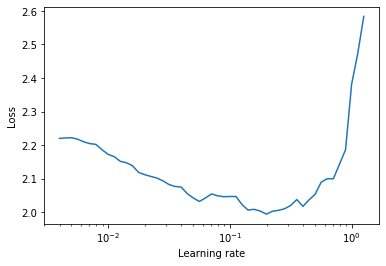

In [3]:
from torch_lr_finder import LRFinder

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
lr_finder.plot()
lr_finder.reset()

This LR find operation shows that the optimal cyclical learning rate is in the `(0.1, 0.5)` min-max range. I use this information to set the learning rate policy accordingly.

Not all learning rate schedulers in PyTorch are **chainable**. Chainable learning rate schedulers are those which may be combined with one another (chained). The one-cycle learning rate scheduler is not chainable. This means that for example it is not possible to combine it with `ReduceLROnPlateau`. At least not trivially...it is possible to do it by staging the training, and using this learning rate scheduler in place of that one late in the training. [See this GH issue](https://github.com/pytorch/pytorch/issues/13022).

The one-cycle learning rate scheduler is a new contribution to the package! You need at least PyTorch version 1.3.0 to have it, whilst the default environment in Spell is PyTorch 1.4.0. So we have to add `torch==1.4.0` to our run to get the right version onboarded.

In [6]:
!spell login --identity #### --password ####

Hello, Aleksey Bilogur!


In [14]:
!spell run 'python models/model_6.py'\
    --machine-type 'V100'\
    --pip 'torch==1.4.0'\
    --mount 'uploads/bob-ross-kaggle-dataset':'/spell/bob-ross-kaggle-dataset'\
    --github-url 'https://github.com/ResidentMario/unet-pytorch.git'\
    --tensorboard-dir '/spell/tensorboards/'

💫 Casting spell #170…
✨ Stop viewing logs with ^C
✨ Machine_Requested… done -- waiting for a V100 machine.
🌟 Building…   Downloading torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl (753.4 …^C

✨ Your run is still running remotely.
✨ Use 'spell kill 170' to terminate your run
✨ Use 'spell logs 170' to view logs again


This failed with "the NVIDIA driver on your system is too old". Whoa, that's not good! Unfortunately this means that Spell is incompatible with the one-cycle learning rate scheduler. I will fall back to cosine annealing.